<a href="https://colab.research.google.com/github/amandinha-gomes/analise_forecasting_ceaps/blob/main/analise_forecasting_ceaps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install prophet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from prophet import Prophet
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_csv("dataset_ceaps_forecasting.csv")
df.head()

,ds,y
0,2018-01-01,13062.46
1,2018-01-02,61972.66
2,2018-01-03,54424.44
3,2018-01-04,21775.57
4,2018-01-05,41703.32


### Tratamento dos dados

In [5]:
df["ds"] = pd.to_datetime(df["ds"])
df = df.sort_values("ds")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1461 non-null   datetime64[ns]
 1   y       1461 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 23.0 KB


### Visualização inicial (série temporal)

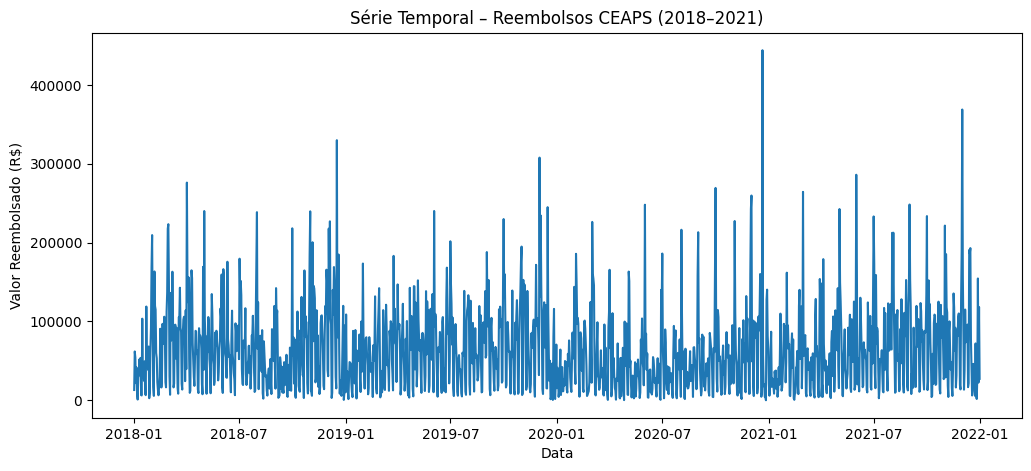

In [7]:
plt.figure(figsize=(12,5))
plt.plot(df["ds"], df["y"])
plt.title("Série Temporal – Reembolsos CEAPS (2018–2021)")
plt.xlabel("Data")
plt.ylabel("Valor Reembolsado (R$)")
plt.show()

### Baseline — Média móvel (modelo simples)

In [8]:
df["MEDIA_90D"] = df["y"].rolling(window=90).mean()

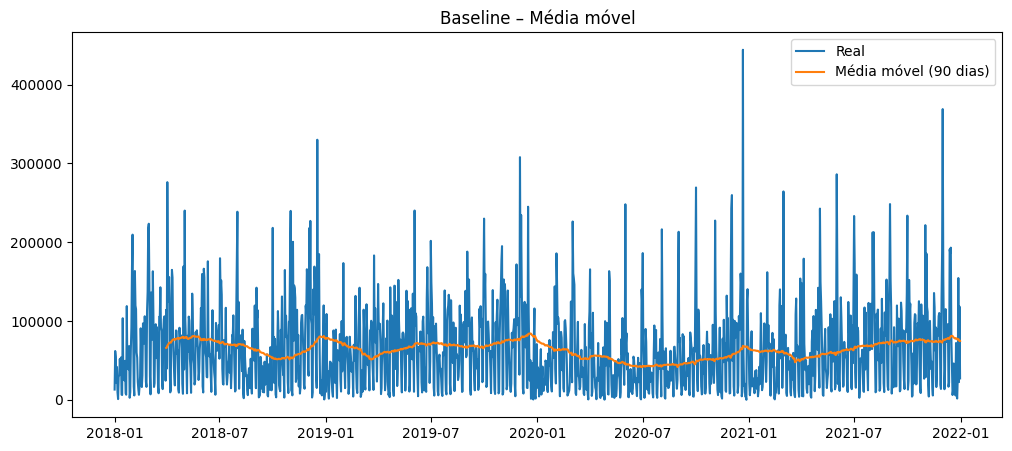

In [9]:
plt.figure(figsize=(12,5))
plt.plot(df["ds"], df["y"], label="Real")
plt.plot(df["ds"], df["MEDIA_90D"], label="Média móvel (90 dias)")
plt.legend()
plt.title("Baseline – Média móvel")
plt.show()

### Split treino / teste (Forecasting)

In [10]:
train = df[df["ds"] < "2021-10-01"]
test  = df[df["ds"] >= "2021-10-01"]

### Modelo Prophet

In [11]:
prophet_df = train[["ds", "y"]].rename(columns={"DS": "ds", "Y": "y"})

In [12]:
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

model.fit(prophet_df)

### Forecast

In [13]:
future = model.make_future_dataframe(periods=len(test))
forecast = model.predict(future)

forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-01,71674.971541,25054.467888,127210.740128,71674.971541,71674.971541,4357.777777,4357.777777,4357.777777,36751.020601,36751.020601,36751.020601,-32393.242824,-32393.242824,-32393.242824,0.0,0.0,0.0,76032.749317
1,2018-01-02,71663.450191,7027.136102,106665.165146,71663.450191,71663.450191,-14725.282842,-14725.282842,-14725.282842,19955.216742,19955.216742,19955.216742,-34680.499584,-34680.499584,-34680.499584,0.0,0.0,0.0,56938.167349
2,2018-01-03,71651.928841,8646.281048,110307.007132,71651.928841,71651.928841,-13950.943113,-13950.943113,-13950.943113,22551.396643,22551.396643,22551.396643,-36502.339757,-36502.339757,-36502.339757,0.0,0.0,0.0,57700.985728
3,2018-01-04,71640.407491,-7047.463046,96516.600740,71640.407491,71640.407491,-25299.674800,-25299.674800,-25299.674800,12547.714559,12547.714559,12547.714559,-37847.389359,-37847.389359,-37847.389359,0.0,0.0,0.0,46340.732692
4,2018-01-05,71628.886141,-11202.995167,85429.600478,71628.886141,71628.886141,-36690.793154,-36690.793154,-36690.793154,2022.120691,2022.120691,2022.120691,-38712.913846,-38712.913846,-38712.913846,0.0,0.0,0.0,34938.092987


#### Visualização do Forecast

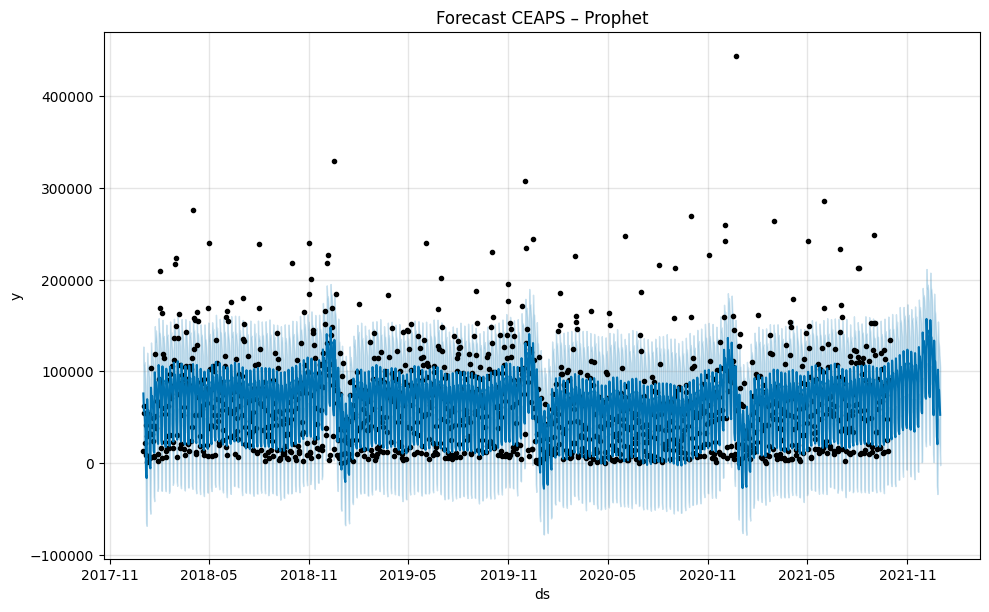

In [14]:
fig = model.plot(forecast)
plt.title("Forecast CEAPS – Prophet")
plt.show()

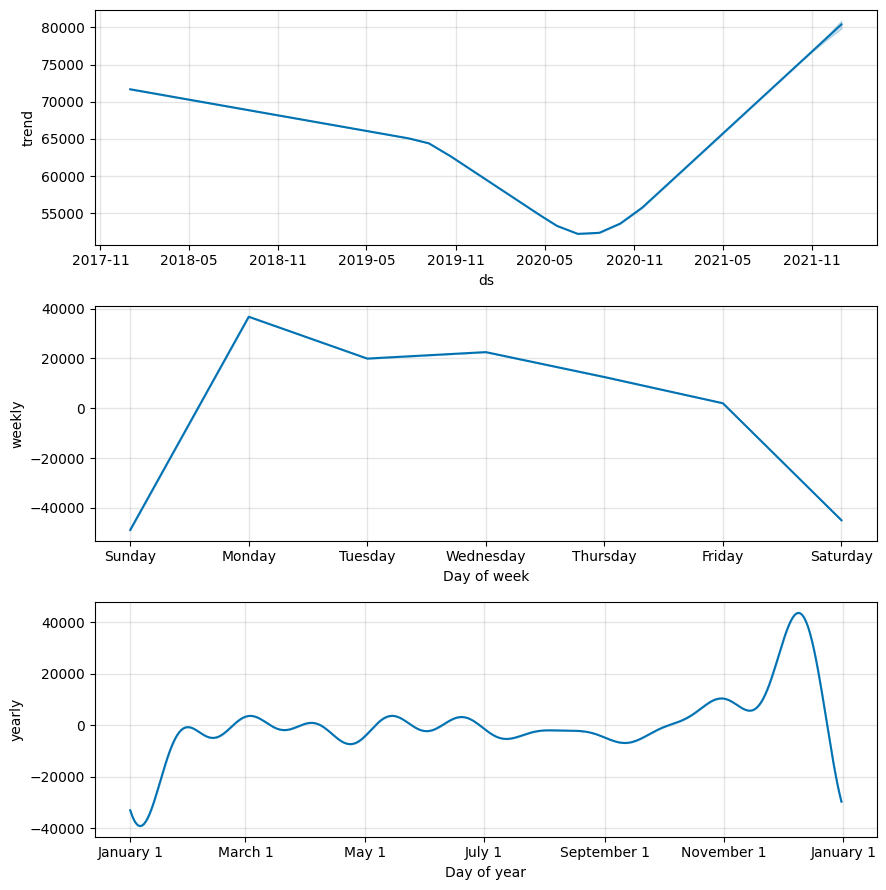

In [15]:
model.plot_components(forecast)
plt.show()

### Avaliação do modelo

In [18]:
forecast_test = forecast[forecast["ds"].isin(test["ds"])]

y_true = test["y"].values
y_pred = forecast_test["yhat"].values

#### Métricas

RMSE

In [19]:
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
rmse

np.float64(51831.2301133857)

MAPE

In [20]:
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape

np.float64(150.9483416793567)

### Comparação visual (Real x Previsto)

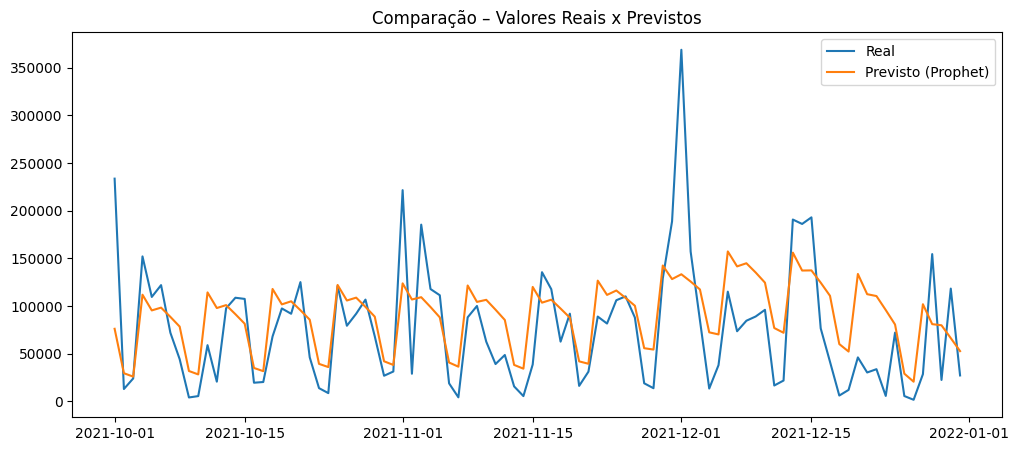

In [22]:
plt.figure(figsize=(12,5))
plt.plot(test["ds"], y_true, label="Real")
plt.plot(test["ds"], y_pred, label="Previsto (Prophet)")
plt.legend()
plt.title("Comparação – Valores Reais x Previstos")
plt.show()